# Employee Churn - Exploratory Analysis

The aim of this notebook is to understand why an employee is willing to quit his job.

In particular, we will explore sociodemographic data to identify relationships.

This falls in a **binary classification** problem, as the target variable, 'target', can only assume 2 values
i.e. either loyal (0.0) or not (1.0) 

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score



## Loading the dataset

In this section we define the path of the dataset of interest, and we load it as **Pandas DataFrame**

In [2]:
# Define the dataset path
data_path = 'datasets/employee-churn'
file_path = os.path.join(data_path, 'churn.csv')

In [3]:
# load the dataset as pd dataframe
df = pd.read_csv(file_path)
# let's plot few rows to understand a first glance the data
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


From these few rows we can alredy get some features properties, such as the column names, the data types, and the presence of NaN values.

To have a deeper view, let's exploit the info() method

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

We are now aware that the dataset is composed by 13 features, and a target variable.

We can basically identify 3 data types:

- int64: 2 instances, i.e. enrollee_id and training_hours
- float64: 2 instances, i.e. city_development_index and the target
- object, a.k.a. string: 10 instances, the remaining features

We can notice that we have 19158 entries. Moreover, we know that 8 out of 13 feature are characterized by the presence of NaN values


## Preprocessing the dataset

Comparing the info's output with the head method, we can quickly spot that some variables are represented as string, but a integer representation would be more straightforward.

To understand better, let's plot the values assumed for those features.

In [5]:
for feature in df.columns[3:12]:
        print(feature.upper())
        print(df[feature].unique())

GENDER
['Male' nan 'Female' 'Other']
RELEVENT_EXPERIENCE
['Has relevent experience' 'No relevent experience']
ENROLLED_UNIVERSITY
['no_enrollment' 'Full time course' nan 'Part time course']
EDUCATION_LEVEL
['Graduate' 'Masters' 'High School' nan 'Phd' 'Primary School']
MAJOR_DISCIPLINE
['STEM' 'Business Degree' nan 'Arts' 'Humanities' 'No Major' 'Other']
EXPERIENCE
['>20' '15' '5' '<1' '11' '13' '7' '17' '2' '16' '1' '4' '10' '14' '18'
 '19' '12' '3' '6' '9' '8' '20' nan]
COMPANY_SIZE
[nan '50-99' '<10' '10000+' '5000-9999' '1000-4999' '10/49' '100-500'
 '500-999']
COMPANY_TYPE
[nan 'Pvt Ltd' 'Funded Startup' 'Early Stage Startup' 'Other'
 'Public Sector' 'NGO']
LAST_NEW_JOB
['1' '>4' 'never' '4' '3' '2' nan]


As expected, some features are represented as strings, but they can actually be transformed into int without losing interpretability.

- To do so, we can start by removing the 'city_' prefix from the city feature.
- Then, we can think the strings with \<x (with x a number) as the nearest lower integer, and the opposite for the string \>x.
- For the company size instead, we can adopt the interval lower end.
- Finally, we can safely assume that when a value is NaN, the user did not specify any value, thus we can all transform that to -1, to be a separate group. In fact, if we imagine those data coming from a survey, is very likely that a number of users do not fill all the fields.

In [6]:
# Let's convert the city feature to int
df['city'] = df['city'].map(lambda row: int(row.split('_')[1]))
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


For the following features, such as:
- experience
- company_size
- last_new_job

We can define ad-hoc mapping functions to better handle all the possible values assumed

In [7]:
# define an ad-hoc function
def convert_experience_to_int(row):
    if row is np.nan:
        return '-1'
    elif row == '<1':
        return '0'
    elif row == '>20':
        return '21'
    else:
        return row

# Apply it!
df['experience'] = df['experience'].map(convert_experience_to_int).astype(np.int8)
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,21,NaN,NaN,1,36,1.0
1,29725,40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,0,NaN,Pvt Ltd,never,52,1.0
4,666,162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,21,50-99,Funded Startup,4,8,0.0


In [8]:
# Now map the company size, accordint to the unique method, we have:
# COMPANY_SIZE
# ['ns' '50-99' '<10' '10000+' '5000-9999' '1000-4999' '10/49' '100-500' '500-999']
# Let's map to int exploiting the lower end. 'ns' = -1 and <10 = 0

# define an ad hoc function
def convert_size_to_int(row):
    if row is np.nan:
        row = -1
    elif '+' in row:
        row = 10000
    elif '/' in row:
        row = 10
    elif '<' in row:
        row = 0
    elif '-' in row:
        row = row.split('-')[0]
        
    
    return int(row)

df['company_size'] = df['company_size'].map(convert_size_to_int)
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,21,-1,NaN,1,36,1.0
1,29725,40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50,Pvt Ltd,>4,47,0.0
2,11561,21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,-1,NaN,never,83,0.0
3,33241,115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,0,-1,Pvt Ltd,never,52,1.0
4,666,162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,21,50,Funded Startup,4,8,0.0


In [9]:
# now do that for last_new_job
# LAST_NEW_JOB
# ['1' '>4' 'never' '4' '3' '2' 'ns']
def convert_last_job_to_int(row):
    if row is np.nan:
        return -1
    elif '>' in row:
        return 4
    elif row == 'never':
        return 0
    else:
        return int(row)
    
df['last_new_job'] = df['last_new_job'].map(convert_last_job_to_int)
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,21,-1,NaN,1,36,1.0
1,29725,40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50,Pvt Ltd,4,47,0.0
2,11561,21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,-1,NaN,0,83,0.0
3,33241,115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,0,-1,Pvt Ltd,0,52,1.0
4,666,162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,21,50,Funded Startup,4,8,0.0


As we can see from the last *.head()* method, we have transformed the set of features mentioned before in a ML-like way.

As the feature *education_level* is ordinal, we must define a meaningfull mapping that preserves the level

In [10]:
def convert_ed_level_to_int(row):
    if row is np.nan:
        return -1
    elif row == 'Primary School':
        return 0
    elif row == 'High School':
        return 1
    elif row == 'Graduate':
        return 2
    elif row == 'Masters':
        return 3
    elif row == 'Phd':
        return 4
    else:
        return row
    
df['education_level'] = df['education_level'].map(convert_ed_level_to_int)
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,103,0.920,Male,Has relevent experience,no_enrollment,2,STEM,21,-1,NaN,1,36,1.0
1,29725,40,0.776,Male,No relevent experience,no_enrollment,2,STEM,15,50,Pvt Ltd,4,47,0.0
2,11561,21,0.624,NaN,No relevent experience,Full time course,2,STEM,5,-1,NaN,0,83,0.0
3,33241,115,0.789,NaN,No relevent experience,NaN,2,Business Degree,0,-1,Pvt Ltd,0,52,1.0
4,666,162,0.767,Male,Has relevent experience,no_enrollment,3,STEM,21,50,Funded Startup,4,8,0.0


As the operations that we will perform on the dataset (visualization, building a model ...) requires to have all numerical values, we need a method to transform the remaining features that currently are represented as string. To do so, we can adopt the OneHot Encoding technique, but we will do that after data visualization.

## Target Distribution

Examining the target variable distribution is a crucial step to understand whether the dataset is balanced or not. If not balanced we will adopt some techniques aimed to remove the Class Imbalance bias

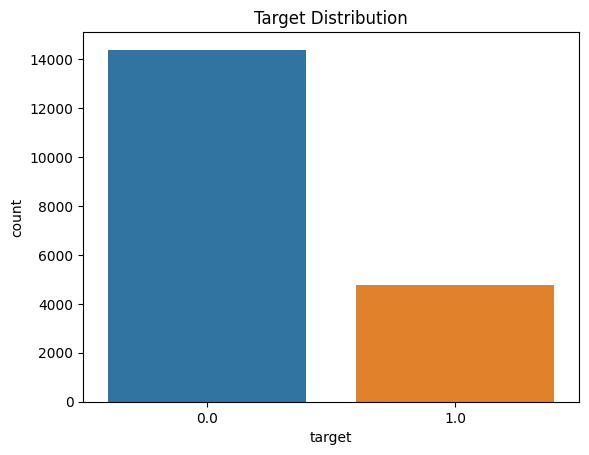

In [11]:
sns.countplot(df, x='target')
plt.title('Target Distribution')
plt.show()

The dataset is highly imbalanced in favor of class 0, i.e. the willingness of an employee to keep his job.

Talking about percentages, we have:

In [12]:
class_proportions = df['target'].value_counts(normalize=True)
class_proportions

target
0.0    0.750652
1.0    0.249348
Name: proportion, dtype: float64

We can now separate the target from the remaining features, to be suitable for the sklearn algorithms.

Moreover, we can avoid the *enrollee_id* column as it is just an identifier and it does not provide any useful insight

In [13]:
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]

print(X.shape)
print(y.shape)

(19158, 12)
(19158,)


## Explore the dataset

We can start by checking the correlation among features. In case we have an high value (positive or negative) between two or more features, we can think about excluding one of those features. We have to factorize the data to have all numerical values.

In [14]:
# let's take a dataframe copy to be used in successive steps
# as for data visualization we will convert categorical features in a scale 0 to n
# but for fitting the model we should instead use the one hot encoding, to prevent misleading information
factorized_df = df.copy()


# Define a list of string features to be converted in numerical values
to_convert = [
    'gender',
    'relevent_experience',
    'enrolled_university',
    'major_discipline',
    'company_type'
]

factorized_df[to_convert] = factorized_df[to_convert].apply(lambda x: pd.factorize(x)[0])


    
factorized_df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,103,0.920,0,0,0,2,0,21,-1,-1,1,36,1.0
1,29725,40,0.776,0,1,0,2,0,15,50,0,4,47,0.0
2,11561,21,0.624,-1,1,1,2,0,5,-1,-1,0,83,0.0
3,33241,115,0.789,-1,1,-1,2,1,0,-1,0,0,52,1.0
4,666,162,0.767,0,0,0,3,0,21,50,1,4,8,0.0


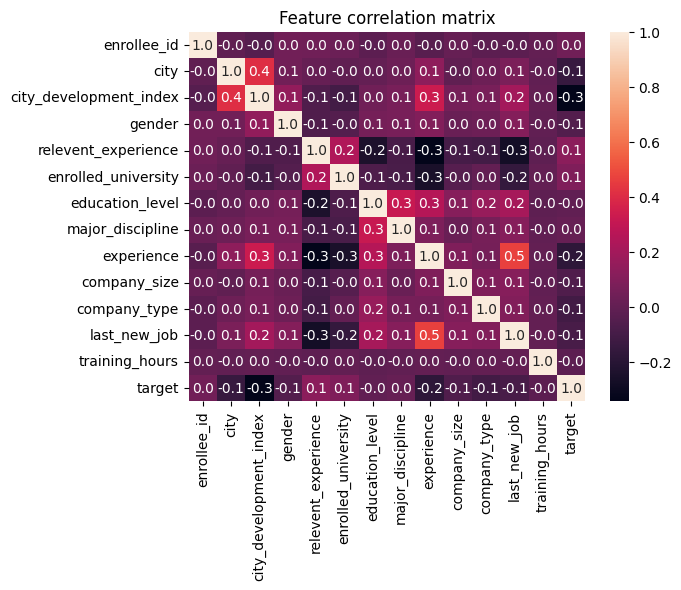

In [15]:
corr = factorized_df.corr()
sns.heatmap(corr, annot=True, fmt='.1f')
plt.title('Feature correlation matrix')
plt.show()

We can see that there are not strong correllations, but we have a noticeable relationship between experience and last_new_job. However, the value .5 is not enough to exclude one among these features.

Before diving in some data visualization, let's talk about the features type:

- city: nominal
- city_development_index: continuos
- gender: nominal
- relevent_experience: ordinal
- enrolled_university: nominal
- education level: ordinal
- major_discipline: nominal
- experience: ordinal
- company_size: ordinal
- company_type: nominal
- last_new_job: ordinal
- major_discipline: nominal
- training_hours: discrete

We will use violin plot for categorical (nominal and ordinal) data, kde for continuous, and histogram for descrete.

> CARE: we have to keep in mind that the carniality of the target class is different depending on the label (i.e. 75% 0, 25% 1), thus we must normalize the data accordingly


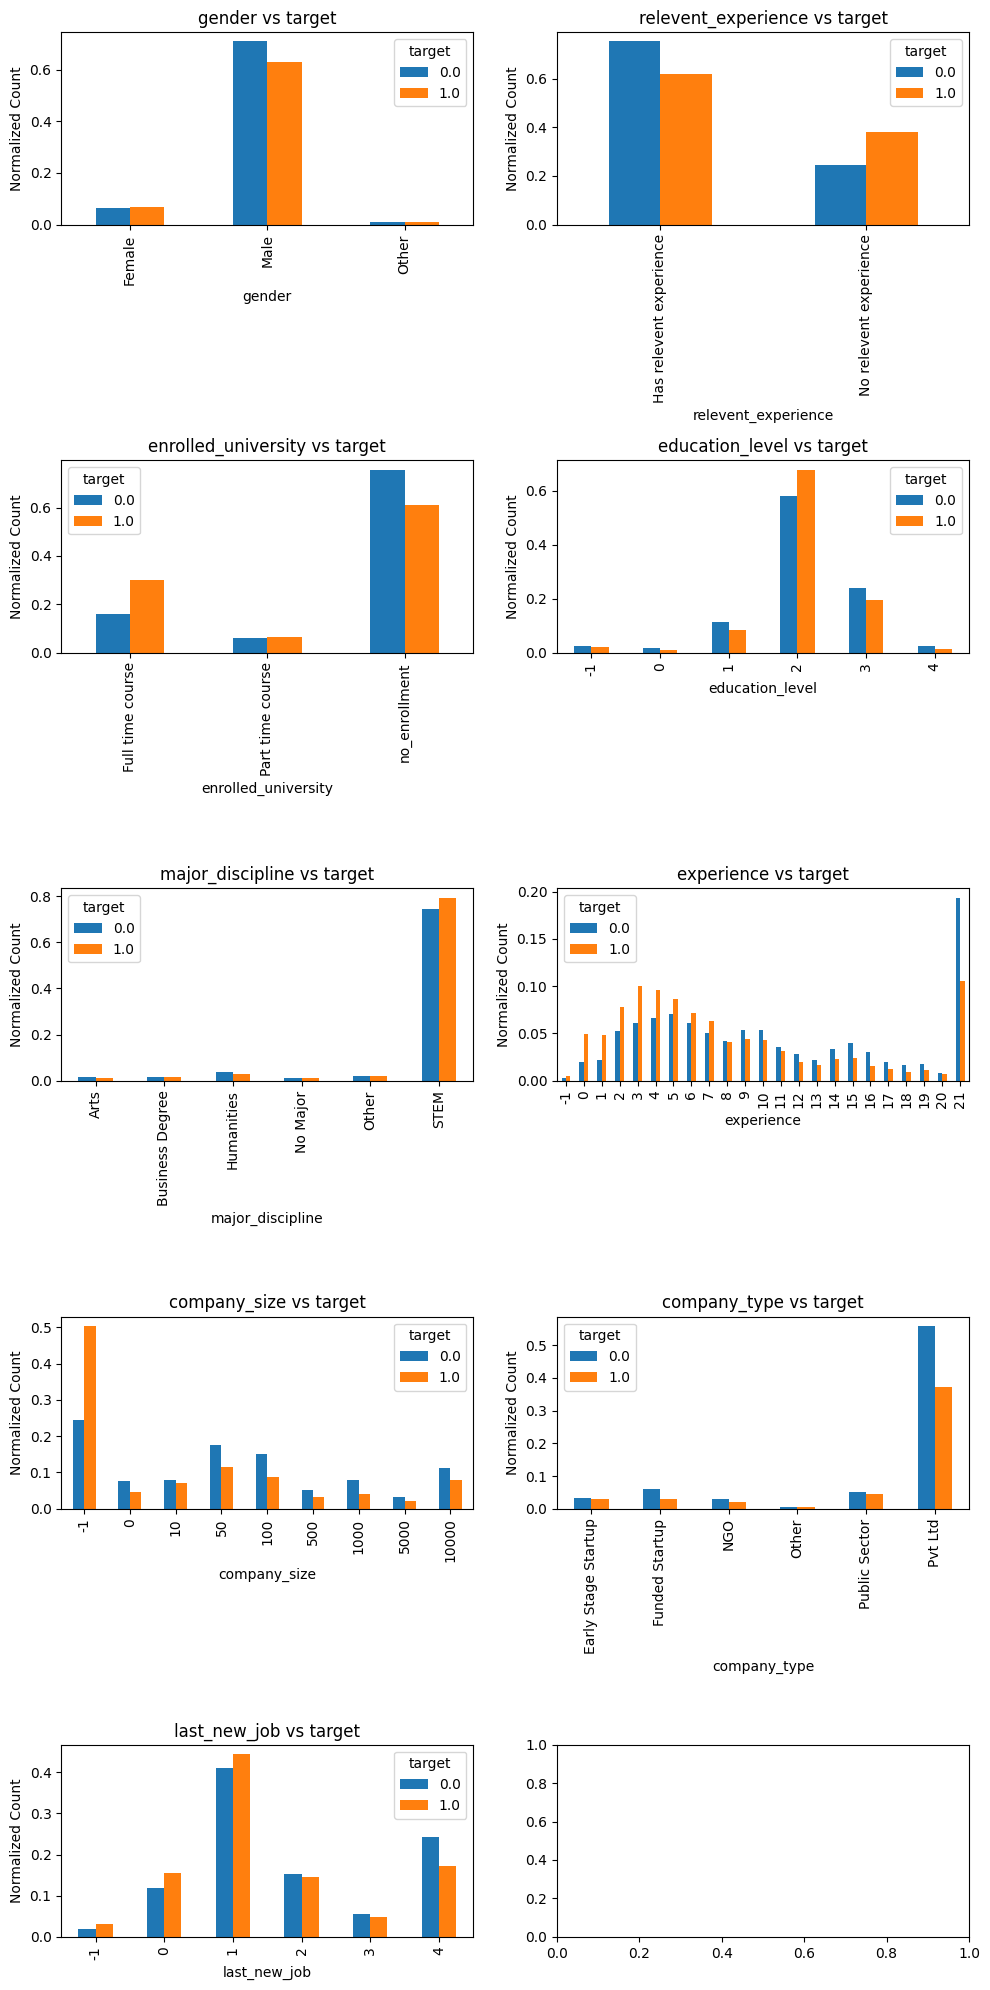

In [16]:
# let's plot the features vs target, using boxplots for categorical data and kde for continuos data
categorical_features = [
    'gender',
    'relevent_experience',
    'enrolled_university',
    'education_level',
    'major_discipline',
    'experience',
    'company_size',
    'company_type',
    'last_new_job'
]

# fig, ax = plt.subplots(3, 3, figsize=(10,6))
# for i, feat in enumerate(categorical_features):
#     sns.barplot(df, x=feat, y=feat, hue='target', ax=ax[int(np.floor(i/3)), i%3])
#     ax[int(np.floor(i/3)), i%3].set_title(f'{feat} vs target')
# fig.tight_layout()
# plt.show()

fig, ax = plt.subplots(5, 2, figsize=(10, 20))
for i, feat in enumerate(categorical_features):
    # Calculate normalized counts by class
    normalized_counts = df.groupby([feat, 'target']).size().unstack().div(
        df['target'].value_counts(), axis=1
    )

    # Plot normalized counts as bar chart
    normalized_counts.plot(kind='bar', ax=ax[int(np.floor(i // 2)), i % 2])
    ax[int(np.floor(i // 2)), i % 2].set_title(f'{feat} vs target')
    ax[int(np.floor(i // 2)), i % 2].set_ylabel('Normalized Count')
fig.tight_layout()
plt.show()

/Users/rubenberteletti/Desktop/xtream/xtream-ai-assignment/pyenv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


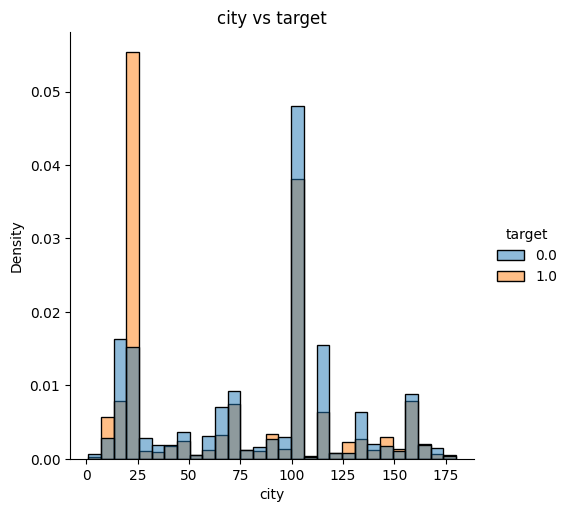

In [17]:
# histograms for discrete features 
sns.displot(df, x='city', hue='target', common_norm=False, stat='density')
plt.title('city vs target')
plt.show()

In [18]:
# let's analyze which city has the the probability to leave the job higher that to keep 
keep_job_df = df[df.target == 0.0].groupby('city').count()['target']
leave_job_df = df[df.target == 1.0].groupby('city').count()['target']
# take the difference
diff = leave_job_df-keep_job_df
# pick the top 2
diff.nlargest(2)

city
21    492.0
11     47.0
Name: target, dtype: float64

In [19]:
# let's retrive its development index
print(df[df.city == 21]['city_development_index'].iloc[0])
print(df[df.city == 11]['city_development_index'].iloc[0])

0.624
0.55


/Users/rubenberteletti/Desktop/xtream/xtream-ai-assignment/pyenv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


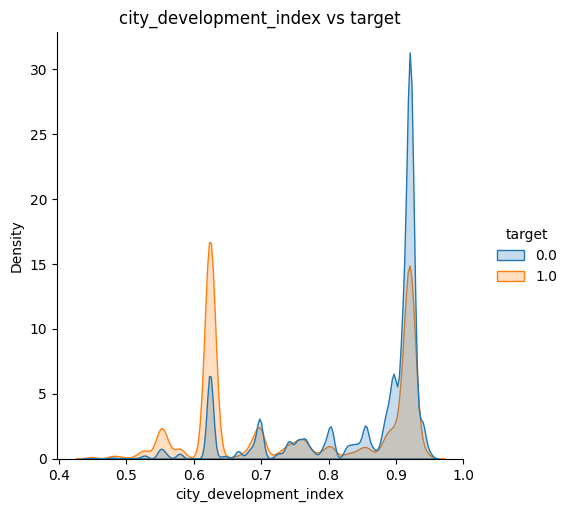

In [20]:
sns.displot(df, x='city_development_index', hue='target', kind='kde', fill=True, common_norm=False, bw_adjust=.3)
plt.title('city_development_index vs target')
plt.show()

/Users/rubenberteletti/Desktop/xtream/xtream-ai-assignment/pyenv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


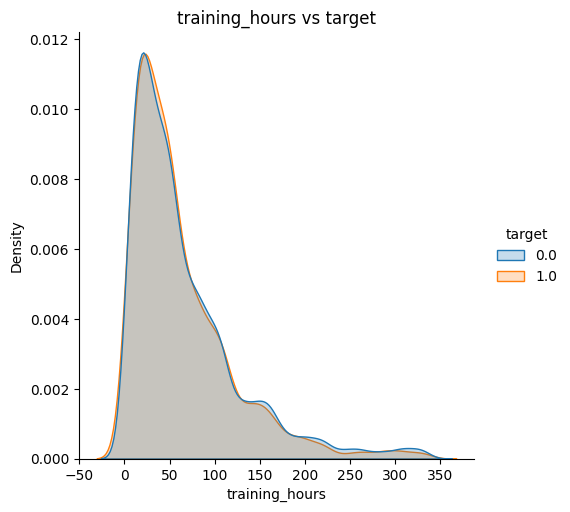

In [21]:
sns.displot(df, x='training_hours', hue='target', kind='kde', fill=True, common_norm=False)
plt.title('training_hours vs target')
plt.show()

The data visualization tells us that the features that can better distinguish among a loyal and not-loyal employee are:
- experience
- city_develpment_index
- company_type
- company_size

Plus, we have an anomaly in city 21, where the employees are more prone to change their job.

We can say that, because the aformentioned features have visible difference of distribution depending on the target value.

From the analysis we can can conclude that:
1. Employees with less than 7 years of experience are more willing to leave their job, especially those with less than 4 years
2. When an employee has a job located in a city with development index that falls in the interval [0.5 to 0.65], he has tendency to quit the job
3. If either the company type and the company size is not specified, the employee has more likelyhood to change job.
5. City 21 rejects employees.

A next step could be interesting to inspect whether employees with less than 11 years are concentrated arount cities whose index falls in the aformentioned interval

/Users/rubenberteletti/Desktop/xtream/xtream-ai-assignment/pyenv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/sz/0_c7pq1x46x0lrvl4jmzh97m0000gn/T/ipykernel_7480/2943300844.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


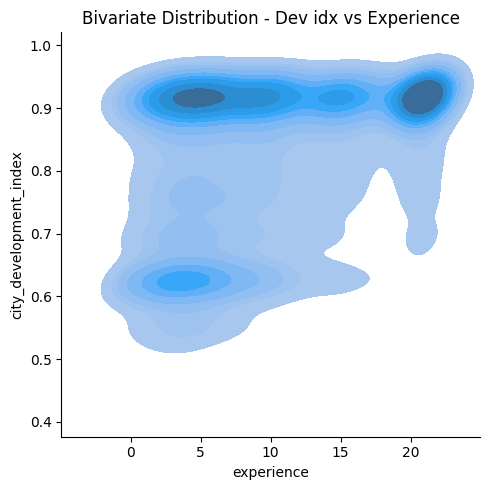

In [22]:
sns.displot(df, x='experience', y='city_development_index', kind='kde', fill=True)
plt.title('Bivariate Distribution - Dev idx vs Experience')
plt.tight_layout()
plt.show()

There is no evidence of a connection of the two variables, as stated also by the correlation matrix (even if it shows only linear relationship)

#### Proposed Solutions

The data suggests that the city is a strong discriminant factor. Additionally, the analysis indicates that employees with more experience are less likely to churn their job. Based on these findings, the management might consider implementing periods of remote work or, if feasible, offering opportunities for employee relocation.

## Challenge 2 - 3

Let's prepare the data to be trained.

Let's apply now the one hot encoding, but before fill the original df with 'not specified' instead of nan values

In [23]:
# fill nan values
df = df.fillna('not_speficied')
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,103,0.920,Male,Has relevent experience,no_enrollment,2,STEM,21,-1,not_speficied,1,36,1.0
1,29725,40,0.776,Male,No relevent experience,no_enrollment,2,STEM,15,50,Pvt Ltd,4,47,0.0
2,11561,21,0.624,not_speficied,No relevent experience,Full time course,2,STEM,5,-1,not_speficied,0,83,0.0
3,33241,115,0.789,not_speficied,No relevent experience,not_speficied,2,Business Degree,0,-1,Pvt Ltd,0,52,1.0
4,666,162,0.767,Male,Has relevent experience,no_enrollment,3,STEM,21,50,Funded Startup,4,8,0.0


A swe have to deal with nominal data, we have to use the OneHot Encoding technique to prevent the model to gather some undesired relationships.

In [24]:
# instantiate the encoder
enc = OneHotEncoder()
# separate featuers to be encoded
X_to_encode = df[['city', 'gender', 'relevent_experience', 'enrolled_university', 'major_discipline', 'company_type']]
# get the targets
y = df.iloc[:, -1]
# apply the encoding
X_to_encode = enc.fit_transform(X_to_encode).toarray()
# create a DataFrame from the encoded data
encoded_df = pd.DataFrame(X_to_encode, columns=enc.get_feature_names_out(enc.feature_names_in_))
# get the non-categorical features from the original DataFrame
non_categorical_cols = ['city_development_index', 'experience', 'company_size', 'last_new_job', 'training_hours', 'education_level']
X_non_categorical = df[non_categorical_cols]
# combine the encoded and non-categorical features
X_encoded = pd.concat([X_non_categorical, encoded_df], axis=1)
X_encoded.head()


,city_development_index,experience,company_size,last_new_job,training_hours,education_level,city_1,city_2,city_7,city_8,...,major_discipline_Other,major_discipline_STEM,major_discipline_not_speficied,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,company_type_not_speficied
0,0.920,21,-1,1,36,2,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.776,15,50,4,47,2,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.624,5,-1,0,83,2,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.789,0,-1,0,52,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.767,21,50,4,8,3,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Now we have 152 features due to the OneHotEncoding tecnique. To keep interpretabiliy, we need to reduce the amount of features.

One way of doing that is to use the feature_selection module provided by sklearn, using the *SelectKBest* class. It requires a scoring function to ptoperly select the best features, and among those available we can use *f_scoring*, that basically performs an ANalysis Of VAriance by computing the difference in means of features values belonging to different classes, then, it selects the most discriminative.

In our case, we have to privilege interpretability, thus, we will keep the number of feautures as low as possible

In [25]:

feature_selector = SelectKBest(f_classif, k=4)
X_new = feature_selector.fit_transform(X_encoded, y)
best_features = feature_selector.get_feature_names_out()
# create a new dataframe
X_final = pd.DataFrame(X_new, columns=best_features)
X_final.head()


,city_development_index,experience,city_21,company_type_not_speficied
0,0.920,21.0,0.0,1.0
1,0.776,15.0,0.0,0.0
2,0.624,5.0,1.0,1.0
3,0.789,0.0,0.0,0.0
4,0.767,21.0,0.0,0.0


This confirms the results obtained with the exploratory analysis and data visualization

### Define train-test-data

To build our model we need to fit a model on a training set, and testing its performance on unseen data to validate the results.
Let's that split the data in train and test set, with a reasonable proportion of 70-30.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, train_size=.7, random_state=0, stratify=y)

We are dealing with an highly imbalanced dataset, thus, we can think about an oversampling techinique such as SMOTE to prevent the algorithm to see mostly 0.0 targets.

In [27]:
# apply the oversampling
X_over, y_over = SMOTE().fit_resample(X_train, y_train)

# explore the result before, and after
print('BEFORE SMOTE')
print(np.unique(y_train, return_counts=True))
print('AFTER SMOTE')
print(np.unique(y_over, return_counts=True))

BEFORE SMOTE
(array([0., 1.]), array([10066,  3344]))
AFTER SMOTE
(array([0., 1.]), array([10066, 10066]))


Now the two classes are perfectly balanced.

We are ready to select a model suited for our task. As we mostly want interpretable result, we can adopt the Decision Tree Classifier.

As strategy to fit the dataset, we can adopt the cross validation method, using the recall as reference metric.

Why *recall*?

Precision is defined as TP/(TP+FN) with TP true positive and FN false negative. Thus it calculates ratio of correctly predicted positive instances to the total actual positive instances. As the management wants to prevent the churn, we want to minimize the false negative probability. This because, a false negative is associated with an employee that is willing to quit his job that can potentially be retained in  the company by taking some actions.

In [28]:
tree = DecisionTreeClassifier(random_state=0, max_depth=3)
result = cross_validate(tree, X_over, y_over, cv=5, scoring=['accuracy', 'recall'], return_estimator=True)
# the result variable as defiend above is a dictionary with a set of keys
print(result.keys())
result['test_recall']


dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'test_recall'])


array([0.75409836, 0.76613704, 0.76154993, 0.76602086, 0.78092399])

In the results there are many metrics. In this case we are interested in 'estimator' and 'test_score'.

With the latter key we can get the model performance over the 5 splits defined in the cross_validate method, and through estimator we can get the best model

In [29]:
# Print mean and std of 5 splits
print(f'Mean Recall: {result["test_recall"].mean():.2f}\tStd: {result["test_recall"].std():.2f}')
# get the best classifier, the one with highest accuracy
best_tree = result['estimator'][np.argmax(result['test_recall'])]

Mean Recall: 0.77	Std: 0.01


We obtained 75 % of recall it the training set, and we have selected the best tree selected among 5 defined with the cross-validate method.
That method consist in dividing the training set in 5 split (by default, but you can choose), and iterating using one of them as test set and the remaing 4 as training set.

To give an idea on how the decision tree works, we can plot its structure, that can be assopciated with a flow chart

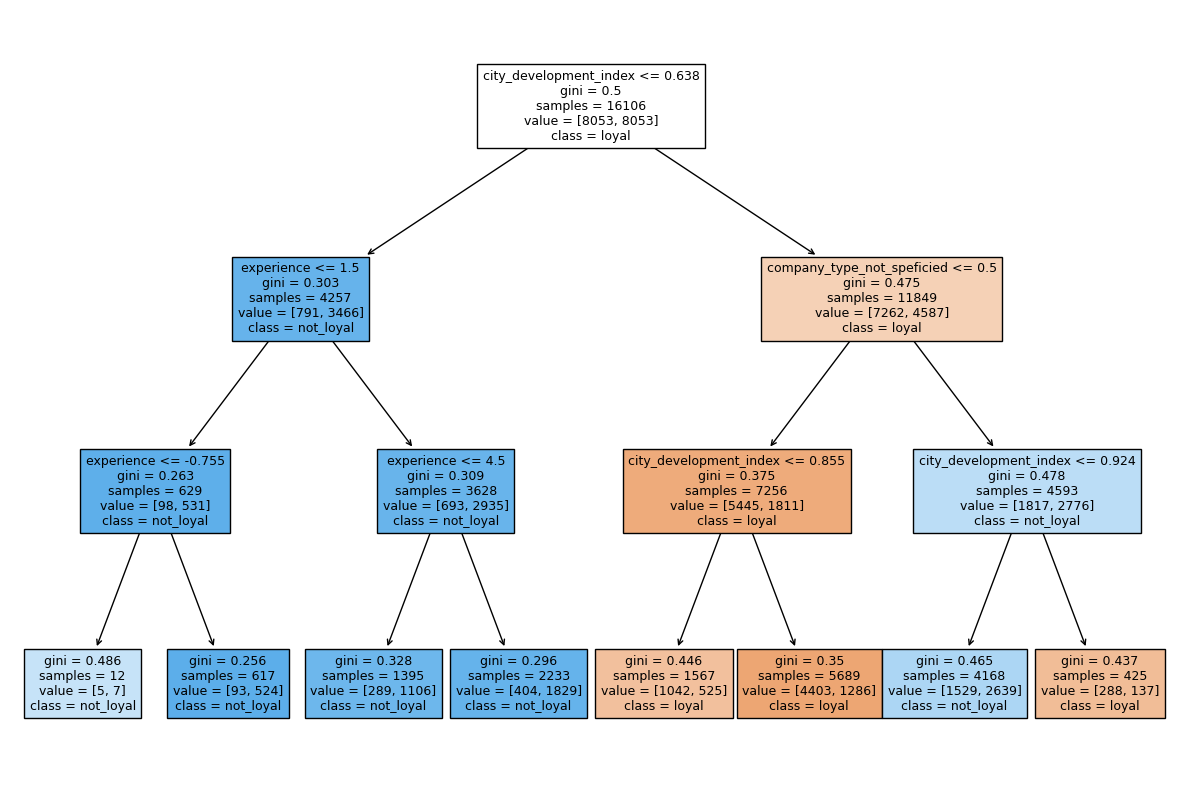

In [30]:
fig, ax = plt.subplots(figsize=(15,10))
# map labels to string to more interpretability
y_map = {0:'loyal', 1:'not_loyal'}
y_str = y_over.map(lambda label: y_map[label]).to_list()
plot_tree(best_tree, feature_names=X_final.columns.tolist(), filled=True, ax=ax, fontsize=9, class_names=y_str)
plt.show()

Let's now evaluate the how the model behaves in the test set

In [31]:
# predict the test set label
y_pred = best_tree.predict(X_test)
# evaluate the recall
recall = recall_score(y_true=y_test, y_pred=y_pred)
print(f'Test recall: {recall*100.0:.2f} %')

Test recall: 75.85 %


We obtained 75.85% of recall, very similar to the training one, thus the model is not overfitted!

We can pick at random some instanced to verify the model predictions

In [32]:
samples = X_test.sample(10, random_state=0)
y_true = y_test[samples.index]

y_preds = best_tree.predict(samples)

print('True Labels:')
print(y_true.to_list())
print('Predicted Labels:')
print(list(y_preds))

True Labels:
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
Predicted Labels:
[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]


We have some misclassifications, however we the model correctly predicts 7 out of 10 samples.